In [1]:
from pydicom import dcmread
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import nibabel as nib
import SimpleITK as sitk

In [15]:

dict_info = {}
input = dcmread('D:\Downloads\VNRealData\File0.dcm')
list_info = [['0x0010', '0x0010'], ['0x0008', '0x0060'], ['0x0010', '0x0020'], ['0x0018', '0x0015'], ['0x0008', '0x0022']]
for i in range(len(list_info)):
    x, y = list_info[i][0], list_info[i][1]
    # Convert x and y into strings of hexadecimal digits
    x_hex = hex(int(x))[2:]
    y_hex = hex(int(y))[2:]
    # Get the last two digits of x and y
    x_last = x_hex[-2:]
    y_last = y_hex[-2:]
    # Use the last two digits to construct the tag
    print(int(x_last, 16), int(y_last, 16))
    tag = (0x00 + int(x_last, 16), 0x00 + int(y_last, 16))
    print(tag)
    if tag in input:
        category = input[tag]
        dict_info[category.name] = category.value
        
        
dict_info

10 10
(10, 10)
8 60
(8, 60)
10 20
(10, 20)
18 15
(18, 15)
8 22
(8, 22)


{'SOP Class UID': '1.2.840.10008.5.1.4.1.1.2'}

(nan, nan)

In [48]:
img_raw = sitk.ReadImage('../DeepLearning/data/MM_WHS/train_images/ct_train_1001_image.nii.gz', sitk.sitkFloat32)
img = sitk.GetArrayFromImage(img_raw)
image = img[:,100,:]


In [49]:
x, y = np.min(image), np.max(image) 
x,y

(-1024.0, 1279.0)

In [ ]:
1442 15403

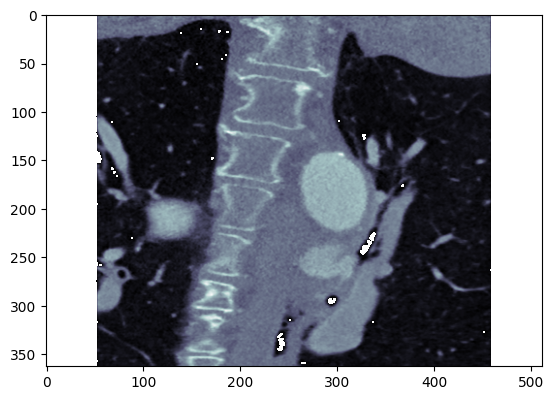

In [47]:
image = np.where((image >= -1000) & (image <= 15403), image, np.nan)
plt.imshow(image, cmap=plt.cm.bone)
plt.show()

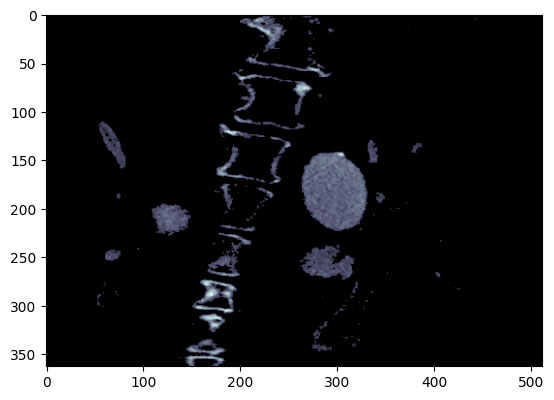

In [50]:
# Set a threshold value for bone
threshold = 300

# Apply thresholding to the image
image = np.where(image > threshold, image, 0)

# Plot the image with cmap=plt.cm.bone
plt.imshow(image, cmap=plt.cm.bone)
plt.show()

In [40]:
plt.imsave("temp.jpg", image, cmap=plt.cm.bone)

In [31]:
if (list_info[0][0], list_info[0][1]) in input:
    category = input[list_info[0][0], list_info[0][1]]
    print(category.name)
    
tag

Patient's Name


(8, 22)

In [28]:
patient_name = input[list_info[0][0], list_info[0][1]]
print(patient_name.name)

Patient's Name
